from https://towardsdatascience.com/bayesian-neural-networks-with-tensorflow-probability-fbce27d6ef6

In [1]:
# Load libriaries and functions.
import pandas as pd
import numpy as np
import tensorflow as tf
tfk = tf.keras
tf.keras.backend.set_floatx("float64")
import tensorflow_probability as tfp
tfd = tfp.distributions
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import IsolationForest

# Define helper functions.
scaler = StandardScaler()
detector = IsolationForest(n_estimators=1000, behaviour="deprecated", contamination="auto", random_state=0)
neg_log_likelihood = lambda x, rv_x: -rv_x.log_prob(x)

In [2]:
# Load data and keep only first six months due to drift.
data = pd.read_excel(r"C:\Users\DAW85586\OneDrive - Mott MacDonald\Documents\MachineLearning\Bayesian\AirQualityUCI\AirQualityUCI.xlsx")
data = data[data["Date"] <= "2004-09-10"]

In [3]:
data

Date      Time  CO(GT)  PT08.S1(CO)  NMHC(GT)   C6H6(GT)  \
0    2004-03-10  18:00:00     2.6      1360.00       150  11.881723   
1    2004-03-10  19:00:00     2.0      1292.25       112   9.397165   
2    2004-03-10  20:00:00     2.2      1402.00        88   8.997817   
3    2004-03-10  21:00:00     2.2      1375.50        80   9.228796   
4    2004-03-10  22:00:00     1.6      1272.25        51   6.518224   
...         ...       ...     ...          ...       ...        ...   
4417 2004-09-10  19:00:00     3.2      1218.25      -200  17.372686   
4418 2004-09-10  20:00:00     2.6      1136.25      -200  12.942854   
4419 2004-09-10  21:00:00     1.4      1016.75      -200   8.221421   
4420 2004-09-10  22:00:00     1.6      1062.50      -200   9.157955   
4421 2004-09-10  23:00:00     1.7      1083.25      -200   9.286931   

      PT08.S2(NMHC)  NOx(GT)  PT08.S3(NOx)  NO2(GT)  PT08.S4(NO2)  \
0           1045.50    166.0       1056.25    113.0       1692.00   
1            954.75    103.0       1173.75     92.0       1558.75   
2            939.25    131.0       1140.00    114.0       1554.50   
3            948.25    172.0       1092.00    122.0       1583.75   
4            835.50    131.0       1205.00    116.0       1490.00   
...             ...      ...           ...      ...           ...   
4417        1221.00    385.0        754.50    180.0       1599.00   
4418        1081.75    307.0        823.50    159.0       1477.50   
4419         908.25    194.0        932.25    119.0       1353.50   
4420         945.50    205.0        886.25    127.0       1390.75   
4421         950.50    223.0        879.50    131.0       1392.50   

      PT08.S5(O3)       T         RH        AH  
0         1267.50  13.600  48.875001  0.757754  
1          972.25  13.300  47.700000  0.725487  
2         1074.00  11.900  53.975000  0.750239  
3         1203.25  11.000  60.000000  0.786713  
4         1110.00  11.150  59.575001  0.788794  
...           ...     ...        ...       ...  
4417      1290.00  29.200  26.850000  1.070896  
4418      1129.75  27.700  30.050000  1.099106  
4419       879.75  27.150  31.025000  1.099065  
4420       996.00  26.025  33.375001  1.107071  
4421      1054.25  25.100  35.724998  1.122236  

[4422 rows x 15 columns]

In [4]:
# Select columns and remove rows with missing values.
columns = ["PT08.S1(CO)", "PT08.S3(NOx)", "PT08.S4(NO2)", "PT08.S5(O3)", "T", "AH", "CO(GT)", "C6H6(GT)", "NOx(GT)", "NO2(GT)"]
data = data[columns].dropna(axis=0)
# Scale data to zero mean and unit variance.
X_t = scaler.fit_transform(data)
# Remove outliers.
is_inlier = detector.fit_predict(X_t)
X_t = X_t[(is_inlier > 0),:]
# Restore frame.
dataset = pd.DataFrame(X_t, columns=columns)
# Select labels for inputs and outputs.
inputs = ["PT08.S1(CO)", "PT08.S3(NOx)", "PT08.S4(NO2)", "PT08.S5(O3)", "T", "AH"]
outputs = ["CO(GT)", "C6H6(GT)", "NOx(GT)", "NO2(GT)"]

In [5]:
# Define some hyperparameters.
n_epochs = 50
n_samples = dataset.shape[0]
n_batches = 10
batch_size = np.floor(n_samples/n_batches)
buffer_size = n_samples
# Define training and test data sizes.
n_train = int(0.7*dataset.shape[0])
# Define dataset instance.
data = tf.data.Dataset.from_tensor_slices((dataset[inputs].values, dataset[outputs].values))
data = data.shuffle(n_samples, reshuffle_each_iteration=True)
# Define train and test data instances.
data_train = data.take(n_train).batch(batch_size).repeat(n_epochs)
data_test = data.skip(n_train).batch(1).repeat(n_epochs)

In [6]:
# Define prior for regularization.
prior = tfd.Independent(tfd.Normal(loc=tf.zeros(len(outputs), dtype=tf.float64), scale=1.0), reinterpreted_batch_ndims=1)
# Define model instance.
model = tfk.Sequential([
tfk.layers.InputLayer(input_shape=(len(inputs),), name="input"),
tfk.layers.Dense(10, activation="relu", name="dense_1"),
tfk.layers.Dense(tfp.layers.MultivariateNormalTriL.params_size(
len(outputs)), activation=None, name="distribution_weights"),
tfp.layers.MultivariateNormalTriL(len(outputs), activity_regularizer=tfp.layers.KLDivergenceRegularizer(prior, weight=1/n_batches), name="output")
], name="model")
# Compile model.
model.compile(optimizer="adam", loss=neg_log_likelihood)
# Run training session.
history = model.fit(data_train, epochs=n_epochs, validation_data=data_test, verbose=False)
# Describe model.
model.summary()

Instructions for updating:
Do not pass `graph_parents`.  They will  no longer be used.
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 10)                70        
_________________________________________________________________
distribution_weights (Dense) (None, 14)                154       
_________________________________________________________________
output (MultivariateNormalTr ((None, 4), (None, 4))    0         
Total params: 224
Trainable params: 224
Non-trainable params: 0
_________________________________________________________________


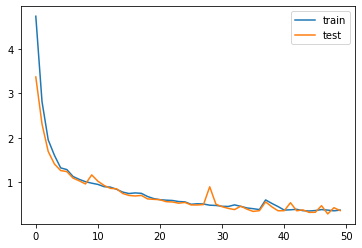

In [8]:
import matplotlib.pyplot as plt
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

In [9]:
tfp.layers.DenseFlipout(10, activation="relu", name="dense_1")

In [10]:
# Predict.
samples = 500
iterations = 10
test_iterator = tf.compat.v1.data.make_one_shot_iterator(data_test)
X_true, Y_true, Y_pred = np.empty(shape=(samples, len(inputs))), np.empty(shape=(samples, len(outputs))), np.empty(shape=(samples, len(outputs), iterations))
for i in range(samples):
    features, labels = test_iterator.get_next()
    X_true[i,:] = features
    Y_true[i,:] = labels.numpy()
    for k in range(iterations):
        Y_pred[i,:,k] = model.predict(features)
        
# Calculate mean and standard deviation.
Y_pred_m = np.mean(Y_pred, axis=-1)
Y_pred_s = np.std(Y_pred, axis=-1)

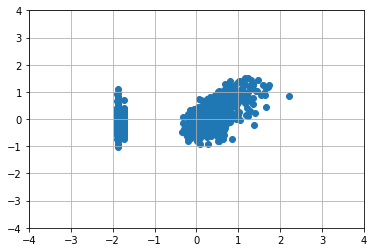

In [11]:

plt.scatter(Y_true, Y_pred_m)
# m, b = np.polyfit(Y_true, Y_pred_m, 1)
# plt.plot(Y_pred_m, m*Y_pred_m + b)
plt.xlim([-4,4])
plt.ylim([-4,4])
plt.grid()


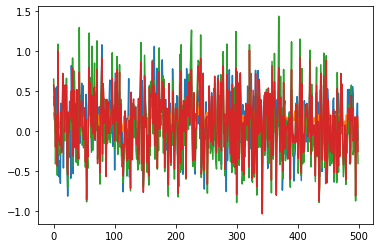

In [77]:
plt.plot(Y_pred_m)
plt.plot(Y_pred_m)

In [36]:
X_true, Y_true

(array([[-0.67001041,  2.05770889, -0.91645643, -1.35023375, -0.04039952,
          0.17418474],
        [ 0.02359979,  0.18396134, -0.05041493, -0.26886198,  0.62146974,
          0.18697645],
        [ 0.79832431, -0.2604156 ,  0.29697338,  0.0464326 ,  0.40329801,
          0.17826545],
        ...,
        [-0.53840657,  0.45510658, -0.06802728, -0.5999846 ,  0.17961072,
          0.20210961],
        [-0.10221018, -0.16166517,  0.40872067,  0.28258697,  0.1955446 ,
          0.18579146],
        [ 0.45565769, -0.7056294 ,  0.72938681,  0.08505302,  0.43271444,
          0.20342835]]),
 array([[ 0.51604927, -0.03345489, -0.13184293,  0.08348267],
        [ 0.52799423,  0.13067697,  0.23232691,  0.60348408],
        [ 0.5363557 ,  0.27755682,  0.50379898,  0.64410919],
        ...,
        [ 0.51366028, -0.00698598, -0.23778325, -0.03839266],
        [ 0.52918872,  0.20037764,  0.29191834,  0.49785879],
        [-1.88010963,  0.24735501,  0.61636056,  0.74973448]]))